In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from fuzzywuzzy import process,fuzz
from collections import defaultdict
from tqdm import tqdm
from scipy.interpolate import griddata
import os
import geopandas as gpd
import contextily as ctx  
from shapely.geometry import Point
from scipy.interpolate import griddata
from matplotlib.colors import Normalize
from matplotlib.patches import Ellipse

tqdm.pandas()

/opt/anaconda3/envs/diya_env/lib/python3.13/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Preprocess

In [2]:
city_tier_df = pd.read_csv("AirQuality/RQ3/Dataset/city_tire.csv")
city_tier_df

,city,Tier
0,Bhilai,Tier2
1,Raipur,Tier2
2,Jaipur,Tier2
3,Navi Mumbai,Tier3
4,Pune,Tier1
...,...,...
284,Perundurai,Tier3
285,Pudukottai,Tier3
286,Madurai,Tier2
287,Ranipet,Tier3


In [3]:
gt_df = pd.read_csv("AirQuality/Dataset/Ground_Truth_2023_Final.csv")

gt_df['year'] = pd.to_datetime(gt_df['YearMonth']).dt.year
gt_df['month'] = pd.to_datetime(gt_df['YearMonth']).dt.month_name()
print(gt_df.columns)
gt_df = gt_df[['city', 'state', 'year', 'month', 'PM2.5','latitude','longitude']].rename(columns={'PM2.5': 'ground_truth_pm25'})

gt_df

Index(['city', 'state', 'YearMonth', 'AT', 'BP', 'PM2.5', 'RF', 'VWS', 'WD',
       'WS', 'latitude', 'longitude', 'year', 'month'],
      dtype='object')


,city,state,year,month,ground_truth_pm25,latitude,longitude
0,Agartala,Tripura,2023,January,196.040103,23.817550,91.272697
1,Agartala,Tripura,2023,February,170.874875,23.817550,91.272697
2,Agartala,Tripura,2023,March,119.490881,23.817550,91.272697
3,Agartala,Tripura,2023,April,94.205356,23.817550,91.272697
4,Agartala,Tripura,2023,May,63.553585,23.817550,91.272697
...,...,...,...,...,...,...,...
2407,Yamuna Nagar,Haryana,2023,August,45.099735,30.148057,77.289347
2408,Yamuna Nagar,Haryana,2023,September,52.957552,30.148057,77.289347
2409,Yamuna Nagar,Haryana,2023,October,72.193644,30.148057,77.289347
2410,Yamuna Nagar,Haryana,2023,November,88.361732,30.148057,77.289347


In [4]:
gemma_9b_df = pd.read_csv("AirQuality/RQ1/Dataset/gemma2_9b_it_2023_predictions.csv")
gemma_27b_df = pd.read_csv("AirQuality/RQ1/Dataset/gemma2_27b_it_2023_predictions.csv")
llama_8b_df = pd.read_csv("AirQuality/RQ1/Dataset/llama3_8b_it_2023_predictions.csv")
llama_70b_df = pd.read_csv("AirQuality/RQ1/Dataset/llama3_70b_it_2023_predictions.csv")
llama1_70b_df = pd.read_csv("AirQuality/RQ1/Dataset/llama3_1_70b_it_2023_predictions.csv")

In [5]:
gemma_9b_df.head()

,city,state,year,month,model,pm2.5
0,Agartala,Tripura,2023,January,google/gemma-2-9b-it,38.7
1,Agartala,Tripura,2023,February,google/gemma-2-9b-it,35.2
2,Agartala,Tripura,2023,March,google/gemma-2-9b-it,35.2
3,Agartala,Tripura,2023,April,google/gemma-2-9b-it,38.7
4,Agartala,Tripura,2023,May,google/gemma-2-9b-it,38.7


> With strict MAE

In [5]:
def compute_metrics(df):
    df = df.dropna(subset=["ground_truth_pm25", "pm2.5"])
    if df.empty:
        return {
            "MAE": np.nan,
            "Over %": np.nan,
            "Under %": np.nan,
            "MAEunder": np.nan,
            "MAEover": np.nan,
            "Samples": 0
        }

    gt = df["ground_truth_pm25"]
    pred = df["pm2.5"]

    abs_error = (gt - pred).abs()
    mae = abs_error.mean() 

    under_mask = pred < gt
    over_mask = pred > gt

    mae_under = (gt[under_mask] - pred[under_mask]).abs().mean() if under_mask.any() else np.nan
    mae_over = (pred[over_mask] - gt[over_mask]).abs().mean() if over_mask.any() else np.nan

    total = len(df)
    under_pct = 100 * under_mask.sum() / total
    over_pct = 100 * over_mask.sum() / total

    return {
        "MAE": round(mae, 4),
        "Over %": round(over_pct, 4),
        "Under %": round(under_pct, 4),
        "MAEunder": round(mae_under, 4) if not np.isnan(mae_under) else np.nan,
        "MAEover": round(mae_over, 4) if not np.isnan(mae_over) else np.nan,
        "Samples": total
    }

In [6]:
model_dfs = {
    "gemma-2-9b-it": gemma_9b_df,
    "gemma-2-27b-it": gemma_27b_df,
    "llama-3.1-8b-Instruct": llama_8b_df,
    "llama-3.1-70b-Instruct": llama1_70b_df,
    "llama-3.3-70b-Instruct": llama_70b_df
}

### Are Tier-3 cities are likely to be underpredicted or tier-1 cities are likely to be overpredicted?

In [7]:
def prepare_df(model_df, gt_df, city_tier_df):
    # print(model_df)
    model_df = model_df.copy()
    gt_df = gt_df.copy()
    city_tier_df = city_tier_df.copy()

    for df in [model_df, gt_df]:
        df["city"] = df["city"].str.strip().str.lower()
        df["state"] = df["state"].str.strip().str.lower()
        df["month"] = df["month"].str.strip().str.lower()
        df["year"] = df["year"].astype(int)

    city_tier_df["city"] = city_tier_df["city"].str.strip().str.lower()

    merged = pd.merge(model_df, gt_df, on=["city", "state", "year", "month"], how="inner")
    merged = pd.merge(merged, city_tier_df, on="city", how="left")
    merged["Tier"] = merged["Tier"].fillna("Unknown")

    return merged

In [8]:
rows = []

for model_name, df in model_dfs.items():
    merged = prepare_df(df.copy(), gt_df.copy(), city_tier_df.copy())
    tier1_df = merged[merged["Tier"].str.lower() == "tier1"]

    results = compute_metrics(tier1_df)

    rows.append(results)

summary_df = pd.DataFrame(rows)

In [10]:
summary_df

,MAE,Over %,Under %,MAEunder,MAEover,Samples
0,20.1961,60.4167,39.5833,23.4450,18.0676,96
1,21.4341,89.5833,10.4167,22.0781,21.3592,96
2,25.6935,24.0000,76.0000,31.9502,5.8807,50
3,18.1135,65.6250,34.3750,12.4362,21.0874,96
4,30.0181,85.4167,14.5833,12.0580,33.0844,96


In [11]:
rows = []

for model_name, df in model_dfs.items():
    merged = prepare_df(df.copy(), gt_df.copy(), city_tier_df.copy())
    tier3_df = merged[merged["Tier"].str.lower() == "tier3"]

    results = compute_metrics(tier3_df)

    rows.append(results)

summary_df = pd.DataFrame(rows)

summary_df

,MAE,Over %,Under %,MAEunder,MAEover,Samples
0,29.0477,56.6862,43.3138,35.3941,24.1984,1533
1,36.1700,85.5297,14.4703,33.4497,36.6303,1548
2,41.8379,4.6926,95.3074,43.4851,8.3833,618
3,33.7189,74.8805,25.1195,21.8716,37.6933,1465
4,48.4879,87.8553,12.1447,26.4006,51.5412,1548


### Are poor cities are more likely to be underpredicted?

In [18]:
mpi_df = pd.read_csv("AirQuality/RQ3/Dataset/mpi_2023.csv")

mpi_df.head()

,district,mpi,state
0,Anantapur,0.027,Andhra Pradesh
1,Chittoor,0.022,Andhra Pradesh
2,East Godavari,0.027,Andhra Pradesh
3,Guntur,0.016,Andhra Pradesh
4,Krishna,0.017,Andhra Pradesh


In [8]:
print(mpi_df['mpi'].min())
print(mpi_df['mpi'].max())
print(mpi_df['mpi'].nunique())

0.0
0.285
181


In [13]:
mpi_df.columns

Index(['district', 'mpi', 'state'], dtype='object')

In [9]:
# Assuming your DataFrame is named `mpi_df` and has columns: 'city', 'state', 'mpi'

# Round MPI to 3 decimal places if it's a float with too much precision
mpi_df['mpi'] = mpi_df['mpi'].round(3)

# Count number of cities per unique MPI value
mpi_counts = mpi_df.groupby('mpi')['district'].nunique().reset_index(name='num_cities')

# Sort by MPI (optional)
mpi_counts = mpi_counts.sort_values('mpi').reset_index(drop=True)


In [10]:
mpi_counts

,mpi,num_cities
0,0.000,5
1,0.001,4
2,0.002,3
3,0.003,3
4,0.004,10
...,...,...
176,0.252,1
177,0.262,2
178,0.266,1
179,0.281,1


In [11]:
mpi_df["state"] = mpi_df["state"].str.lower().str.strip()
mpi_df["district"] = mpi_df["district"].str.lower().str.strip()

def get_mpi(row):
    city = row["city"].lower().strip()
    state = row["state"].lower().strip()
    candidates = mpi_df[mpi_df["state"] == state]

    if candidates.empty:
        return np.nan

    candidates = candidates.copy()
    candidates["score"] = candidates["district"].apply(lambda d: fuzz.token_sort_ratio(d, city))

    best_match = candidates.loc[candidates["score"].idxmax()]
    if best_match["score"] >= 80: 
        return best_match["mpi"]
    else:
        return np.nan
    
model_all = []
for model_name, model_df in model_dfs.items():
    df = model_df.copy()
    df["model"] = model_name
    model_all.append(df)

all_models_df = pd.concat(model_all, ignore_index=True)

# Merge with ground truth
merged_df = pd.merge(all_models_df, gt_df, on=["city", "state", "year", "month"], how="inner")

# Apply MPI using fuzzy city ↔ district match (with state)
print("Matching city ↔ district with fuzzy logic...")
merged_df["mpi"] = merged_df.progress_apply(get_mpi, axis=1)

# Drop rows where MPI couldn't be determined
merged_df = merged_df.dropna(subset=["mpi"])

# Split into Low and High MPI
low_mpi_df = merged_df[merged_df["mpi"] < 0.01]
high_mpi_df = merged_df[merged_df["mpi"] >= 0.01]

# Compute metrics
rows = []

for model_name in merged_df["model"].unique():
    low = low_mpi_df[low_mpi_df["model"] == model_name]
    high = high_mpi_df[high_mpi_df["model"] == model_name]

    row = {"Model": model_name}

    low_metrics = compute_metrics(low)
    high_metrics = compute_metrics(high)

    for k, v in low_metrics.items():
        row[f"Low MPI: {k}"] = v
    for k, v in high_metrics.items():
        row[f"High MPI: {k}"] = v

    rows.append(row)

final_mpi_df = pd.DataFrame(rows)

final_mpi_df


Matching city ↔ district with fuzzy logic...


  0%|          | 0/12060 [00:00<?, ?it/s]

100%|██████████| 12060/12060 [00:15<00:00, 767.81it/s]


,Model,Low MPI: MAE,Low MPI: Over %,Low MPI: Under %,Low MPI: MAEunder,Low MPI: MAEover,Low MPI: Samples,High MPI: MAE,High MPI: Over %,High MPI: Under %,High MPI: MAEunder,High MPI: MAEover,High MPI: Samples
0,gemma-2-9b-it,12.9886,58.7719,41.2281,13.2674,12.7929,228,29.3788,61.4186,38.5814,35.3567,25.6236,1283
1,gemma-2-27b-it,18.8012,89.9123,10.0877,6.2319,20.2115,228,37.5428,89.7975,10.2025,33.2771,38.0275,1284
2,llama-3.1-8b-Instruct,20.8835,9.1837,90.8163,22.4774,5.1216,98,38.8259,8.8975,91.1025,41.6522,9.8876,517
3,llama-3.1-70b-Instruct,13.2748,60.1770,39.8230,10.7332,14.9568,226,37.8839,83.3333,16.6667,20.0153,41.4576,1254
4,llama-3.3-70b-Instruct,19.2450,81.1404,18.8596,9.7890,21.4429,228,51.8545,91.1215,8.8785,21.9861,54.7648,1284


In [24]:
model_errors = []
for model_name, df in model_dfs.items():
    merged = df.merge(gt_df, on=["city", "state", "year", "month"], how="inner")
    merged["error"] = merged["pm2.5"] - merged["ground_truth_pm25"]
    merged["underpredicted"] = merged["error"] < 0
    merged["model"] = model_name
    model_errors.append(merged[["city", "state", "year", "month", "model", "underpredicted"]])

all_errors_df = pd.concat(model_errors)

under_by_all = (
    all_errors_df
    .groupby(["city", "state"])
    .agg(num_models=("model", "nunique"), under_all=("underpredicted", "sum"))
    .reset_index()
)

always_under_df = under_by_all[under_by_all["under_all"] == under_by_all["num_models"]].copy()
always_under_df.drop(columns="under_all", inplace=True)

def get_mpi(row):
    city = row["city"]
    state = row["state"]

    candidates = mpi_df[mpi_df["state"].str.lower() == state.lower()].copy()
    if candidates.empty:
        return np.nan

    candidates["score"] = candidates["district"].apply(lambda x: fuzz.token_sort_ratio(x.lower(), city.lower()))
    best = candidates.loc[candidates["score"].idxmax()]
    
    return best["mpi"] if best["score"] >= 80 else np.nan

always_under_df["mpi"] = always_under_df.progress_apply(get_mpi, axis=1)

always_under_df = always_under_df.sort_values(by="mpi", ascending=False)[["city", "state", "num_models", "mpi"]]
always_under_df.reset_index(drop=True, inplace=True)

always_under_df

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00, 551.91it/s]


,city,state,num_models,mpi
0,Sirohi,Rajasthan,4,0.093
1,Moradabad,Uttar Pradesh,4,0.081
2,Palwal,Haryana,4,0.068
3,Jhansi,Uttar Pradesh,4,0.063
4,Raipur,Chhattisgarh,4,0.036
5,Panipat,Haryana,4,0.030
6,Amritsar,Punjab,4,0.014
7,Kanpur,Uttar Pradesh,4,NaN
8,Maihar,Madhya Pradesh,4,NaN


###  Do greener cities (high NDVI) receive cleaner predictions?

In [12]:
ndvi_df = pd.read_csv("AirQuality/RQ3/Dataset/city_monthly_ndvi_2023.csv")
ndvi_df.head()

,city,state,month,avg_ndvi,max_ndvi,min_ndvi,ndvi_range
0,Agartala,Tripura,2023-01,0.363576,0.517691,0.008791,0.508900
1,Agartala,Tripura,2023-02,0.391827,0.555423,-0.005073,0.560495
2,Agartala,Tripura,2023-03,0.435666,0.710977,0.006709,0.704268
3,Agartala,Tripura,2023-04,0.513448,0.642455,-0.000300,0.642755
4,Agartala,Tripura,2023-05,0.322064,0.614464,-0.030768,0.645232


In [13]:
import calendar

def prepare_df(model_df, gt_df, ndvi_df):
    # Clean and standardize
    for d in [model_df, gt_df]:
        d["city"] = d["city"].str.strip().str.lower()
        d["state"] = d["state"].str.strip().str.lower()
        d["month"] = d["month"].str.strip().str.lower()
        d["year"] = d["year"].astype(int)

    ndvi_df = ndvi_df.copy()
    ndvi_df["city"] = ndvi_df["city"].str.strip().str.lower()
    ndvi_df["state"] = ndvi_df["state"].str.strip().str.lower()
    ndvi_df["month"] = ndvi_df["month"].astype(str).str.strip()

    # Merge model and GT
    merged = pd.merge(model_df, gt_df, on=["city", "state", "year", "month"], how="inner")

    # Construct 'month_str' = YYYY-MM
    month_map = {month.lower(): f"{i:02d}" for i, month in enumerate(calendar.month_name) if month}
    merged["month_num"] = merged["month"].map(month_map)
    merged["month_str"] = merged["year"].astype(str) + "-" + merged["month_num"]

    # Join with NDVI data
    ndvi_df.rename(columns={"month": "month_str"}, inplace=True)
    merged = pd.merge(merged, ndvi_df, on=["city", "state", "month_str"], how="left")

    return merged

In [14]:
rows = []

for model_name, df in model_dfs.items():
    # Make copies to avoid modifying originals
    model_df = df.copy()
    gt_df_copy = gt_df.copy()
    ndvi_df_copy = ndvi_df.copy()

    # Lowercase and strip city, state, month columns where present
    for d in [model_df, gt_df_copy]:
        d["city"] = d["city"].str.strip().str.lower()
        d["state"] = d["state"].str.strip().str.lower()
        d["month"] = d["month"].str.strip().str.lower()
        d["year"] = d["year"].astype(int)

    ndvi_df_copy["city"] = ndvi_df_copy["city"].str.strip().str.lower()
    ndvi_df_copy["state"] = ndvi_df_copy["state"].str.strip().str.lower()

    # Merge model_df and gt_df on city, state, year, month
    merged = pd.merge(model_df, gt_df_copy, on=["city", "state", "year", "month"], how="inner")

    # Merge with ndvi_df on city and state
    merged = pd.merge(merged, ndvi_df_copy, on=["city", "state"], how="left")

    # Drop rows with missing avg_ndvi
    merged = merged.dropna(subset=["avg_ndvi"])

    # Compute correlations
    pred_corr = merged["pm2.5"].corr(merged["avg_ndvi"])
    gt_corr = merged["ground_truth_pm25"].corr(merged["avg_ndvi"])

    # NDVI category splits
    ndvi_high = merged[merged["avg_ndvi"] > 0.3]
    ndvi_low = merged[merged["avg_ndvi"] <= 0.3]

    high_metrics = compute_metrics(ndvi_high)
    low_metrics = compute_metrics(ndvi_low)

    rows.append({
        "Model": model_name,

        "Correlation: Predicted vs NDVI": round(pred_corr, 3),
        "Correlation: GroundTruth vs NDVI": round(gt_corr, 3),

        "NDVI > 0.3: MAE": high_metrics["MAE"],
        "NDVI > 0.3: MAEunder": high_metrics["MAEunder"],
        "NDVI > 0.3: MAEover": high_metrics["MAEover"],
        "NDVI > 0.3: Under %": high_metrics["Under %"],
        "NDVI > 0.3: Over %": high_metrics["Over %"],

        "NDVI <= 0.3: MAE": low_metrics["MAE"],
        "NDVI <= 0.3: MAEunder": low_metrics["MAEunder"],
        "NDVI <= 0.3: MAEover": low_metrics["MAEover"],
        "NDVI <= 0.3: Under %": low_metrics["Under %"],
        "NDVI <= 0.3: Over %": low_metrics["Over %"],
    })

summary_df = pd.DataFrame(rows)


In [15]:
summary_df

,Model,Correlation: Predicted vs NDVI,Correlation: GroundTruth vs NDVI,NDVI > 0.3: MAE,NDVI > 0.3: MAEunder,NDVI > 0.3: MAEover,NDVI > 0.3: Under %,NDVI > 0.3: Over %,NDVI <= 0.3: MAE,NDVI <= 0.3: MAEunder,NDVI <= 0.3: MAEover,NDVI <= 0.3: Under %,NDVI <= 0.3: Over %
0,gemma-2-9b-it,0.134,0.07,28.2563,34.0816,24.4654,39.4224,60.5776,26.5059,31.3220,23.2572,40.2824,59.7176
1,gemma-2-27b-it,0.205,0.07,36.9871,33.9457,37.3671,11.1057,88.8943,33.2921,26.8822,34.2836,13.3960,86.6040
2,llama-3.1-8b-Instruct,-0.007,0.07,38.6411,40.9817,9.8768,92.4750,7.5250,36.9091,39.8457,9.1015,90.4481,9.5519
3,llama-3.1-70b-Instruct,0.180,0.07,34.8890,19.0313,38.9063,20.2129,79.7871,31.0536,18.6108,35.5707,26.6340,73.3660
4,llama-3.3-70b-Instruct,0.204,0.07,49.7397,24.8037,52.6605,10.4852,89.5148,44.3609,20.3162,48.1385,13.5777,86.4223


In [22]:
summary_df

,Model,Correlation: Predicted vs NDVI,Correlation: GroundTruth vs NDVI,NDVI > 0.3: MAE,NDVI > 0.3: MAEunder,NDVI > 0.3: MAEover,NDVI > 0.3: Under %,NDVI > 0.3: Over %,NDVI <= 0.3: MAE,NDVI <= 0.3: MAEunder,NDVI <= 0.3: MAEover,NDVI <= 0.3: Under %,NDVI <= 0.3: Over %
0,gemma-2-9b-it,0.134,0.07,28.2563,38.6067,26.9257,34.4147,54.5021,26.5059,35.5130,25.3036,35.1302,54.4148
1,gemma-2-27b-it,0.205,0.07,36.9871,44.4250,38.5858,8.2447,85.7592,33.2921,36.4388,35.7498,9.5301,82.6504
2,llama-3.1-8b-Instruct,-0.007,0.07,38.6411,42.0649,11.1458,90.0000,6.5269,36.9091,41.3303,10.7134,87.0572,7.9473
3,llama-3.1-70b-Instruct,0.180,0.07,34.8890,25.1464,40.9667,14.5814,75.4211,31.0536,23.4397,37.6236,20.4400,69.0625
4,llama-3.3-70b-Instruct,0.204,0.07,49.7397,32.1533,54.6683,7.7853,85.9848,44.3609,24.8471,50.1514,10.7143,82.7005


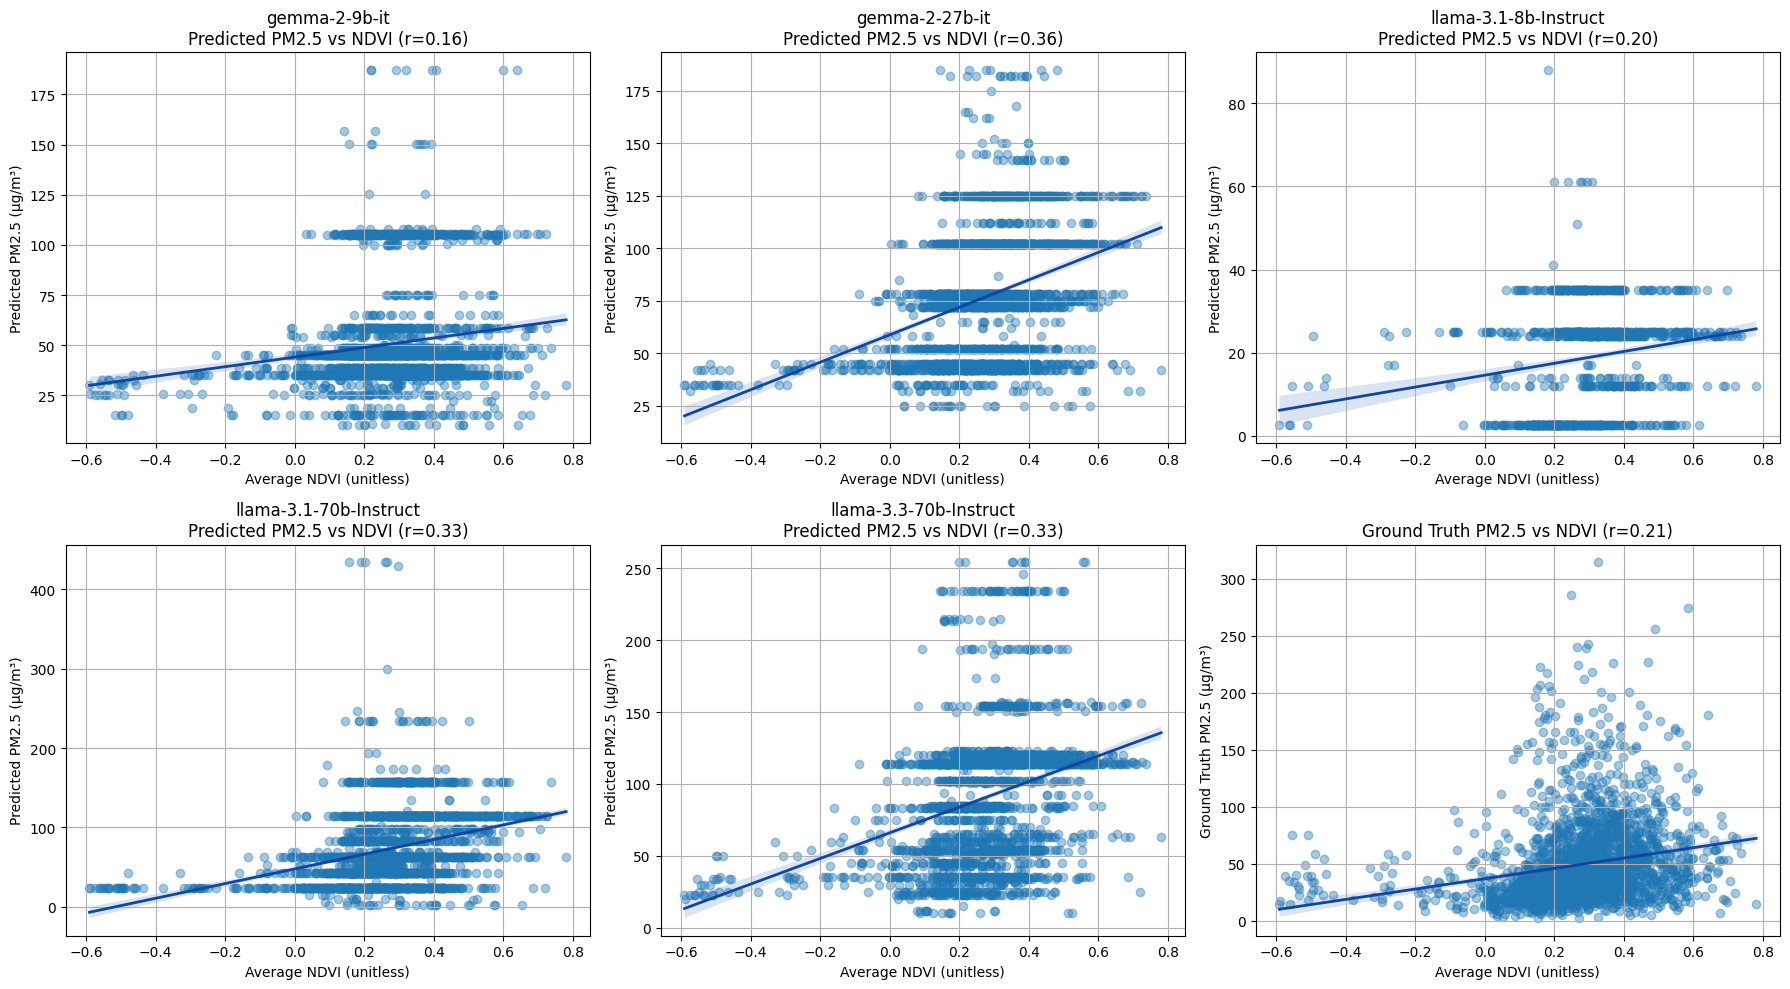

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

model_list = list(model_dfs.items())
axes = axes.flatten()  # Flatten for easier indexing

# Plot for each model
for i, (model_name, df) in enumerate(model_list):
    ax = axes[i]

    merged = prepare_df(df.copy(), gt_df.copy(), ndvi_df.copy())
    merged = merged.dropna(subset=["avg_ndvi"])

    pred_corr = merged["pm2.5"].corr(merged["avg_ndvi"])

    sns.regplot(
        data=merged, x="avg_ndvi", y="pm2.5", ax=ax,
        scatter_kws={'alpha': 0.4, 'color': '#1f77b4'},
        line_kws={"color": "#0d47a1", "lw": 2}
    )
    ax.set_title(f"{model_name}\nPredicted PM2.5 vs NDVI (r={pred_corr:.2f})")
    ax.set_xlabel("Average NDVI (unitless)")
    ax.set_ylabel("Predicted PM2.5 (µg/m³)")
    ax.grid(True)

# Plot for ground truth in the 6th cell
merged_gt = prepare_df(next(iter(model_dfs.values())).copy(), gt_df.copy(), ndvi_df.copy())
merged_gt = merged_gt.dropna(subset=["avg_ndvi"])

gt_corr = merged_gt["ground_truth_pm25"].corr(merged_gt["avg_ndvi"])

ax = axes[len(model_list)]  # 6th plot
sns.regplot(
    data=merged_gt, x="avg_ndvi", y="ground_truth_pm25", ax=ax,
    scatter_kws={'alpha': 0.4, 'color': '#1f77b4'},
    line_kws={"color": "#0d47a1", "lw": 2}
)
ax.set_title(f"Ground Truth PM2.5 vs NDVI (r={gt_corr:.2f})")
ax.set_xlabel("Average NDVI (unitless)")
ax.set_ylabel("Ground Truth PM2.5 (µg/m³)")
ax.grid(True)

# If there are fewer than 5 models, hide remaining subplot(s)
for j in range(len(model_list)+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [66]:
ndvi_df.head()

,city,state,month,avg_ndvi,max_ndvi,min_ndvi,ndvi_range
0,agartala,tripura,2023-01,0.363576,0.517691,0.008791,0.508900
1,agartala,tripura,2023-02,0.391827,0.555423,-0.005073,0.560495
2,agartala,tripura,2023-03,0.435666,0.710977,0.006709,0.704268
3,agartala,tripura,2023-04,0.513448,0.642455,-0.000300,0.642755
4,agartala,tripura,2023-05,0.322064,0.614464,-0.030768,0.645232


### Are cities in the Indo-Gangetic belt consistently underestimated?

In [7]:
indo_gangetic_df = pd.read_csv("AirQuality/RQ3/Dataset/indo_gangetic_cities.csv")

In [22]:
indo_gangetic_df.head()

,City,State
0,Alwar,Rajasthan
1,Bharatpur,Rajasthan
2,Amritsar,Punjab
3,Ludhiana,Punjab
4,Jalandhar,Punjab


In [9]:
indo_cities = indo_gangetic_df.copy()
indo_cities.columns = ['city', 'state']
indo_cities['city'] = indo_cities['city'].str.lower()
indo_cities['state'] = indo_cities['state'].str.lower()

def evaluate_indo_underprediction(model_df):
    model_df = model_df.copy()
    model_df["city"] = model_df["city"].str.lower()
    model_df["state"] = model_df["state"].str.lower()

    gt = gt_df.copy()
    gt["city"] = gt["city"].str.lower()
    gt["state"] = gt["state"].str.lower()

    df = pd.merge(
        model_df,
        gt,
        on=["city", "state", "year", "month"],
        how="inner"
    )

    df = pd.merge(df, indo_cities, on=["city", "state"], how="inner")

    return compute_metrics(df)

results = []

for model_name, df in model_dfs.items():
    metrics = evaluate_indo_underprediction(df)
    metrics["Model"] = model_name
    results.append(metrics)

# Step 5: Create and view the result DataFrame
results_df = pd.DataFrame(results)
results_df

,MAE,Over %,Under %,MAEunder,MAEover,Samples,Model
0,35.3957,67.5926,32.4074,38.2876,34.0092,324,gemma-2-9b-it
1,41.6797,91.0494,8.9506,35.4777,42.2893,324,gemma-2-27b-it
2,41.6402,14.5985,85.4015,46.1980,14.9772,137,llama-3.1-8b-Instruct
3,50.2053,90.1235,9.8765,17.9222,53.7432,324,llama-3.1-70b-Instruct
4,65.3933,94.7531,5.2469,19.5858,67.9298,324,llama-3.3-70b-Instruct


In [25]:
# Step 1: Lowercase indo_cities
indo_cities = indo_gangetic_df.copy()
indo_cities.columns = ['city', 'state']
indo_cities['city'] = indo_cities['city'].str.lower()
indo_cities['state'] = indo_cities['state'].str.lower()

# Step 2: Define the evaluation function for non-IGP cities
def evaluate_non_indo_prediction(model_df):
    model_df = model_df.copy()
    model_df["city"] = model_df["city"].str.lower()
    model_df["state"] = model_df["state"].str.lower()

    gt = gt_df.copy()
    gt["city"] = gt["city"].str.lower()
    gt["state"] = gt["state"].str.lower()

    df = pd.merge(model_df, gt, on=["city", "state", "year", "month"], how="inner")

    # Filter out IGP cities: keep only non-IGP cities
    df = pd.merge(df, indo_cities, on=["city", "state"], how="left", indicator=True)
    df = df[df["_merge"] == "left_only"].drop(columns=["_merge"])  # These are non-IGP cities

    return compute_metrics(df)

# Step 3: Evaluate for all models
non_indo_results = []

for model_name, df in model_dfs.items():
    metrics = evaluate_non_indo_prediction(df)
    non_indo_results.append(metrics)

# Step 4: View the results
non_indo_results_df = pd.DataFrame(non_indo_results)
non_indo_results_df

,MAE,MAEtol,Over %,Under %,Within %,MAEunder,MAEover,Samples
0,26.0649,28.9442,52.9185,36.2277,10.8538,35.8379,24.2248,2073
1,33.6448,36.0724,83.0460,9.5307,7.4234,38.2588,35.8215,2088
2,36.9582,38.6681,6.1249,89.2815,4.5936,40.6959,9.1091,849
3,29.8366,33.0987,68.1363,21.0922,10.7715,24.3888,35.7949,1996
4,43.8011,46.7138,82.9981,10.2969,6.7050,27.1506,49.1409,2088


### Do predictions correlate more with population than pollution?

In [6]:
population_df = pd.read_csv("AirQuality/RQ3/Dataset/Population.csv")

population_df.head()

,city,state,matched_city,level,population,score
0,agartala,tripura,NaN,NaN,NaN,NaN
1,agra,uttar pradesh,NaN,district,4418797.0,100.000000
2,ahmedabad,gujarat,NaN,district,7214225.0,88.888889
3,aizawl,mizoram,NaN,district,400309.0,100.000000
4,ajmer,rajasthan,NaN,district,2583052.0,100.000000


In [7]:
pop_df = population_df.copy()
pop_df["city"] = pop_df["city"].str.lower()
pop_df["state"] = pop_df["state"].str.lower()
pop_df = pop_df[["city", "state", "population"]].drop_duplicates()

gt_df_clean = gt_df.copy()
gt_df_clean["city"] = gt_df_clean["city"].str.lower()
gt_df_clean["state"] = gt_df_clean["state"].str.lower()

gt_city = gt_df_clean.groupby(["city", "state"]).agg(gt_pm25=("ground_truth_pm25", "mean")).reset_index()
gt_merged = pd.merge(gt_city, pop_df, on=["city", "state"], how="inner")

def compute_corr(df, col1, col2):
    df = df[[col1, col2]].dropna()

    if df[col1].nunique() <= 1 or df[col2].nunique() <= 1:
        return round(df[col1].corr(df[col2]), 3), None  

    pearson = df[col1].corr(df[col2])
    spearman = spearmanr(df[col1], df[col2]).correlation
    return round(pearson, 3), round(spearman, 3)

gt_pearson, gt_spearman = compute_corr(gt_merged, "gt_pm25", "population")

results = []

for model_name, model_df in model_dfs.items():
    df = model_df.copy()
    df["city"] = df["city"].str.lower()
    df["state"] = df["state"].str.lower()

    pred_city = df.groupby(["city", "state"]).agg(pred_pm25=("pm2.5", "mean")).reset_index()
    pred_merged = pd.merge(pred_city, pop_df, on=["city", "state"], how="inner")

    p_corr, s_corr = compute_corr(pred_merged, "pred_pm25", "population")

    results.append({
        "Model": model_name,
        "Pearson (Pred vs Pop)": p_corr,
        "Spearman (Pred vs Pop)": s_corr,
        "Pearson (GT vs Pop)": gt_pearson,
        "Spearman (GT vs Pop)": gt_spearman
    })

corr_df = pd.DataFrame(results)

In [29]:
corr_df

,Model,Pearson (Pred vs Pop),Spearman (Pred vs Pop),Pearson (GT vs Pop),Spearman (GT vs Pop)
0,gemma-2-9b-it,0.085,0.161,0.091,0.079
1,gemma-2-27b-it,0.049,0.099,0.091,0.079
2,llama-3.1-8b-Instruct,0.426,0.395,0.091,0.079
3,llama-3.1-70b-Instruct,0.066,0.120,0.091,0.079
4,llama-3.3-70b-Instruct,0.027,0.069,0.091,0.079


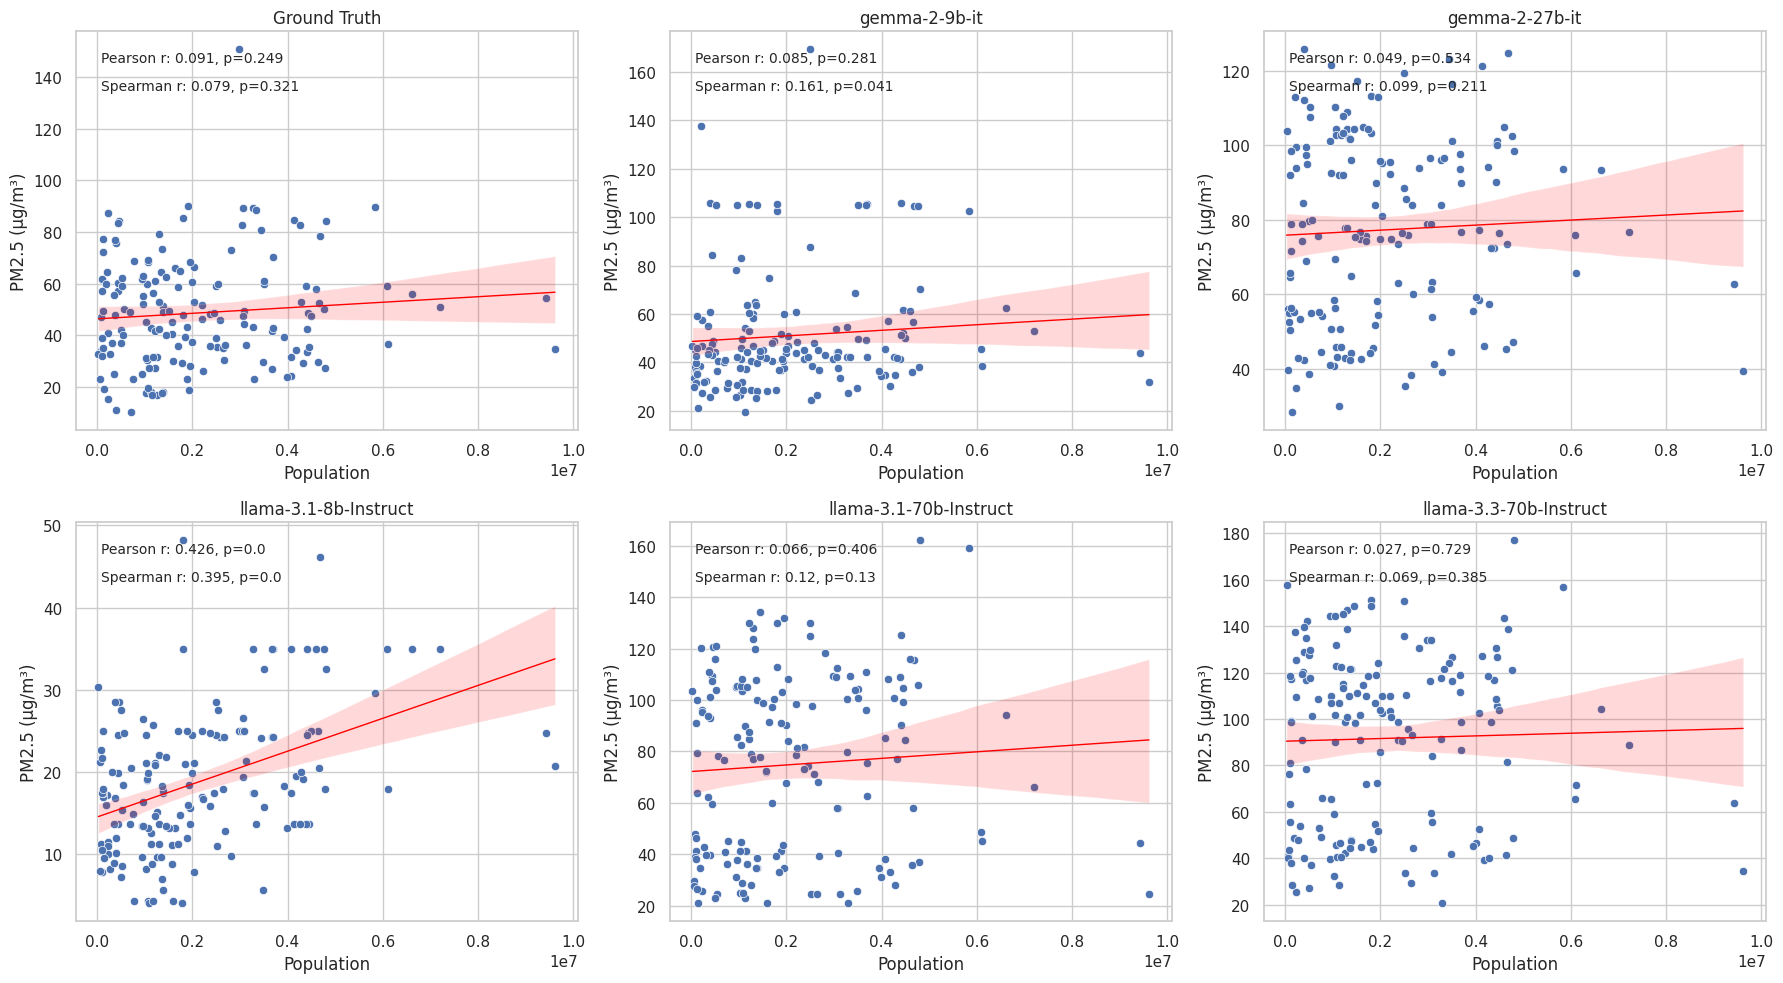

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

# === Prepare plotting ===
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# GT: preprocess
gt_df_clean = gt_df.copy()
gt_df_clean["city"] = gt_df_clean["city"].str.lower()
gt_df_clean["state"] = gt_df_clean["state"].str.lower()
gt_city = gt_df_clean.groupby(["city", "state"]).agg(gt_pm25=("ground_truth_pm25", "mean")).reset_index()

pop_df = population_df.copy()
pop_df["city"] = pop_df["city"].str.lower()
pop_df["state"] = pop_df["state"].str.lower()
pop_df = pop_df[["city", "state", "population"]].drop_duplicates()

gt_merged = pd.merge(gt_city, pop_df, on=["city", "state"], how="inner")
gt_merged["label"] = "Ground Truth"
gt_merged.rename(columns={"gt_pm25": "pm25"}, inplace=True)

# Function to compute Pearson & Spearman
def compute_corr(df, col1, col2):
    df = df[[col1, col2]].dropna()

    if df[col1].nunique() <= 1 or df[col2].nunique() <= 1:
        return None, None, None, None

    pearson_r, pearson_p = pearsonr(df[col1], df[col2])
    spearman_r, spearman_p = spearmanr(df[col1], df[col2])
    
    return round(pearson_r, 3), round(pearson_p, 3), round(spearman_r, 3), round(spearman_p, 3)

# Add Ground Truth
scatter_data = [("Ground Truth", gt_merged)]

# Add all models
for model_name, model_df in model_dfs.items():
    df = model_df.copy()
    df["city"] = df["city"].str.lower()
    df["state"] = df["state"].str.lower()
    pred_city = df.groupby(["city", "state"]).agg(pm25=("pm2.5", "mean")).reset_index()
    merged = pd.merge(pred_city, pop_df, on=["city", "state"], how="inner")
    scatter_data.append((model_name, merged))

# === Plotting ===
for i, (label, df) in enumerate(scatter_data):
    ax = axes[i]
    sns.scatterplot(data=df, x="population", y="pm25", ax=ax)
    sns.regplot(data=df, x="population", y="pm25", scatter=False, ax=ax, 
                line_kws={"color": "red", "linewidth": 1})

    pearson_r, pearson_p, spearman_r, spearman_p = compute_corr(df, "pm25", "population")

    ax.set_title(f"{label}", fontsize=12)
    ax.set_xlabel("Population")
    ax.set_ylabel("PM2.5 (µg/m³)")

    ax.text(0.05, 0.95, f"Pearson r: {pearson_r}, p={pearson_p}", transform=ax.transAxes, fontsize=10, verticalalignment='top')
    ax.text(0.05, 0.88, f"Spearman r: {spearman_r}, p={spearman_p}", transform=ax.transAxes, fontsize=10, verticalalignment='top')

plt.tight_layout()
plt.show()

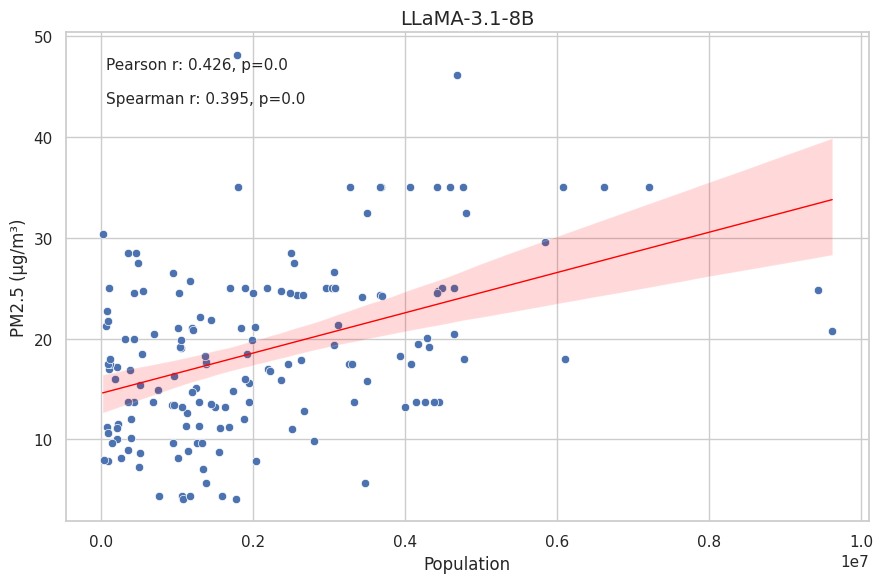

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

# === Prepare plotting ===
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(9, 6))  # single plot, larger size

# Preprocess population dataframe
pop_df = population_df.copy()
pop_df["city"] = pop_df["city"].str.lower()
pop_df["state"] = pop_df["state"].str.lower()
pop_df = pop_df[["city", "state", "population"]].drop_duplicates()

# Select LLaMA-3.1-8B dataframe from model_dfs (adjust key if needed)
llama_key = "llama-3.1-8b-Instruct"
model_df = model_dfs[llama_key].copy()
model_df["city"] = model_df["city"].str.lower()
model_df["state"] = model_df["state"].str.lower()

# Aggregate PM2.5 by city/state and merge with population
pred_city = model_df.groupby(["city", "state"]).agg(pm25=("pm2.5", "mean")).reset_index()
merged = pd.merge(pred_city, pop_df, on=["city", "state"], how="inner")

# Function to compute correlations
def compute_corr(df, col1, col2):
    df = df[[col1, col2]].dropna()
    if df[col1].nunique() <= 1 or df[col2].nunique() <= 1:
        return None, None, None, None
    pearson_r, pearson_p = pearsonr(df[col1], df[col2])
    spearman_r, spearman_p = spearmanr(df[col1], df[col2])
    return round(pearson_r, 3), round(pearson_p, 3), round(spearman_r, 3), round(spearman_p, 3)

# Compute correlations
pearson_r, pearson_p, spearman_r, spearman_p = compute_corr(merged, "pm25", "population")

# Plotting
sns.scatterplot(data=merged, x="population", y="pm25", ax=ax)
sns.regplot(data=merged, x="population", y="pm25", scatter=False, ax=ax,
            line_kws={"color": "red", "linewidth": 1})

ax.set_title("LLaMA-3.1-8B", fontsize=14)
ax.set_xlabel("Population")
ax.set_ylabel("PM2.5 (µg/m³)")

# Add correlation text inside the plot
ax.text(0.05, 0.95, f"Pearson r: {pearson_r}, p={pearson_p}", transform=ax.transAxes, fontsize=11, verticalalignment='top')
ax.text(0.05, 0.88, f"Spearman r: {spearman_r}, p={spearman_p}", transform=ax.transAxes, fontsize=11, verticalalignment='top')

plt.tight_layout()
plt.show()

### Are coastal cities consistently underpredicted?

In [45]:
coastal_df = pd.read_csv("AirQuality/RQ3/Dataset/coastal_cities.csv")

coastal_df.head()

,City,State
0,Porbandar,Gujarat
1,Veraval,Gujarat
2,Bhavnagar,Gujarat
3,Okha,Gujarat
4,Surat,Gujarat


In [46]:
# === Step 1: Preprocess coastal_df to match formatting ===
coastal_cities = coastal_df.copy()
coastal_cities.columns = ['city', 'state']
coastal_cities['city'] = coastal_cities['city'].str.lower()
coastal_cities['state'] = coastal_cities['state'].str.lower()

# === Step 2: Define evaluation function for coastal underprediction ===
def evaluate_coastal_underprediction(model_df):
    model_df = model_df.copy()
    model_df["city"] = model_df["city"].str.lower()
    model_df["state"] = model_df["state"].str.lower()

    gt = gt_df.copy()
    gt["city"] = gt["city"].str.lower()
    gt["state"] = gt["state"].str.lower()

    # Merge predictions with ground truth
    df = pd.merge(
        model_df,
        gt,
        on=["city", "state", "year", "month"],
        how="inner"
    )

    # Keep only coastal cities
    df = pd.merge(df, coastal_cities, on=["city", "state"], how="inner")

    return compute_metrics(df)

# === Step 3: Run evaluation for each model ===
results = []

for model_name, df in model_dfs.items():
    metrics = evaluate_coastal_underprediction(df)
    results.append({
        "Model": model_name,
        "Under %": metrics["Under %"],
        "MAEunder": metrics["MAEunder"],
        "Over %": metrics["Over %"],
        "MAEover": metrics["MAEover"],
        "Samples": metrics["Samples"],
        "MAE": metrics["MAE"]
    })

# === Step 4: View results ===
results_df = pd.DataFrame(results)
results_df


,Model,Under %,MAEunder,Over %,MAEover,Samples,MAE
0,gemma-2-9b-it,52.2727,19.7399,47.7273,13.4331,132,16.7298
1,gemma-2-27b-it,20.4545,11.1624,79.5455,18.4601,132,16.9674
2,llama-3.1-8b-Instruct,86.2069,28.4265,13.7931,6.2961,58,25.3740
3,llama-3.1-70b-Instruct,49.2424,17.9432,50.7576,10.2573,132,14.0420
4,llama-3.3-70b-Instruct,31.8182,14.4821,68.1818,19.8575,132,18.1471


### Temperature impact on PM2.5

In [48]:
gt_df = pd.read_csv("AirQuality/Dataset/Ground_Truth_2023_Final.csv")

gt_df = pd.read_csv("AirQuality/Dataset/Ground_Truth_2023_Final.csv")

gt_df['year'] = pd.to_datetime(gt_df['YearMonth']).dt.year
gt_df['month'] = pd.to_datetime(gt_df['YearMonth']).dt.month_name()
gt_df = gt_df[['city', 'state', 'year', 'month', 'PM2.5','AT']].rename(columns={'PM2.5': 'ground_truth_pm25'})

gt_df.head()

,city,state,year,month,ground_truth_pm25,AT
0,Agartala,Tripura,2023,January,196.040103,NaN
1,Agartala,Tripura,2023,February,170.874875,NaN
2,Agartala,Tripura,2023,March,119.490881,NaN
3,Agartala,Tripura,2023,April,94.205356,NaN
4,Agartala,Tripura,2023,May,63.553585,NaN


In [49]:
# Filter rows where temperature (AT) is not NaN
valid_temp_df = gt_df[gt_df["AT"].notna()]

# Calculate the range of ground_truth_pm25
pm25_min = valid_temp_df["ground_truth_pm25"].min()
pm25_max = valid_temp_df["ground_truth_pm25"].max()
pm25_range = pm25_max - pm25_min

print(f"PM2.5 Range (where AT is available): {pm25_min:.2f} to {pm25_max:.2f}, Range = {pm25_range:.2f}")


PM2.5 Range (where AT is available): 2.37 to 314.21, Range = 311.85


In [52]:
valid_temp = gt_df[gt_df["AT"].notna()].copy()

valid_temp["city"] = valid_temp["city"].str.lower().str.strip()
valid_temp["state"] = valid_temp["state"].str.lower().str.strip()

avg_temp_per_city = valid_temp.groupby(["city", "state"])["AT"].mean().reset_index()
avg_temp_per_city.columns = ["city", "state", "avg_temp"]

# Use bottom 25% quantile to define low temperature cities
threshold = avg_temp_per_city["avg_temp"].quantile(0.25)
print(f"Low temperature threshold (25th percentile): {threshold:.2f} °C")

low_temp_cities = avg_temp_per_city[avg_temp_per_city["avg_temp"] <= threshold]

def evaluate_low_temp_underprediction(model_df):
    df = model_df.copy()
    df["city"] = df["city"].str.lower().str.strip()
    df["state"] = df["state"].str.lower().str.strip()

    gt = gt_df.copy()
    gt["city"] = gt["city"].str.lower().str.strip()
    gt["state"] = gt["state"].str.lower().str.strip()

    merged_df = pd.merge(df, gt, on=["city", "state", "year", "month"], how="inner")

    merged_df = pd.merge(merged_df, low_temp_cities[["city", "state"]], on=["city", "state"], how="inner")

    return compute_metrics(merged_df)

results = []

for model_name, model_df in model_dfs.items():
    metrics = evaluate_low_temp_underprediction(model_df)
    results.append({
        "Model": model_name,
        "Under %": metrics["Under %"],
        "MAEunder": metrics["MAEunder"],
        "Over %": metrics["Over %"],
        "MAEover": metrics["MAEover"],
        "Samples": metrics["Samples"],
        "MAE": metrics["MAE"]
    })

results_df = pd.DataFrame(results)
results_df

Low temperature threshold (25th percentile): 25.07 °C


,Model,Under %,MAEunder,Over %,MAEover,Samples,MAE
0,gemma-2-9b-it,44.8513,38.4604,55.1487,24.6585,437,30.8488
1,gemma-2-27b-it,18.4685,35.6091,81.5315,33.7070,444,34.0583
2,llama-3.1-8b-Instruct,92.2156,45.5785,7.7844,5.4123,167,42.4518
3,llama-3.1-70b-Instruct,30.5489,23.4560,69.4511,35.6822,419,31.9473
4,llama-3.3-70b-Instruct,14.6396,30.8665,85.3604,46.5444,444,44.2492


### Finding for underpredicted cities with respect to temperature

In [53]:
def get_underpredicted_city_states(model_df, gt_df):
    df = model_df.copy()
    df["city"] = df["city"].str.lower().str.strip()
    df["state"] = df["state"].str.lower().str.strip()

    gt = gt_df.copy()
    gt["city"] = gt["city"].str.lower().str.strip()
    gt["state"] = gt["state"].str.lower().str.strip()

    merged = pd.merge(df, gt, on=["city", "state", "year", "month"], how="inner")
    merged["is_underpredicted"] = merged["pm2.5"] < merged["ground_truth_pm25"]
    
    # Get city-state pairs underpredicted at least once
    under_df = merged[merged["is_underpredicted"]]
    return set(zip(under_df["city"], under_df["state"]))

under_sets = []
for model_name, df in model_dfs.items():
    under_set = get_underpredicted_city_states(df, gt_df)
    under_sets.append(under_set)

# Cities underpredicted by ALL models (intersection)
under_all = set.intersection(*under_sets)

print(f"Number of city-state pairs underpredicted by ALL models: {len(under_all)}")

Number of city-state pairs underpredicted by ALL models: 76


In [54]:
# Prepare average temperature per city-state as before
avg_temp_per_city["city"] = avg_temp_per_city["city"].str.lower().str.strip()
avg_temp_per_city["state"] = avg_temp_per_city["state"].str.lower().str.strip()

under_all_df = pd.DataFrame(list(under_all), columns=["city", "state"])

# Merge with avg temperature
under_all_with_temp = pd.merge(under_all_df, avg_temp_per_city, on=["city", "state"], how="left")

# Show sorted by avg_temp ascending
under_all_with_temp = under_all_with_temp.sort_values("avg_temp")
print(under_all_with_temp)


         city       state   avg_temp
48       ooty  tamil nadu  15.316970
32    gangtok      sikkim  16.732513
68   tumakuru   karnataka  19.342769
29     kohima    nagaland  19.383375
46      tensa      odisha  21.531858
..        ...         ...        ...
60      kochi      kerala        NaN
65       vapi     gujarat        NaN
67   bathinda      punjab        NaN
72    narnaul     haryana        NaN
75  nandesari     gujarat        NaN

[76 rows x 3 columns]


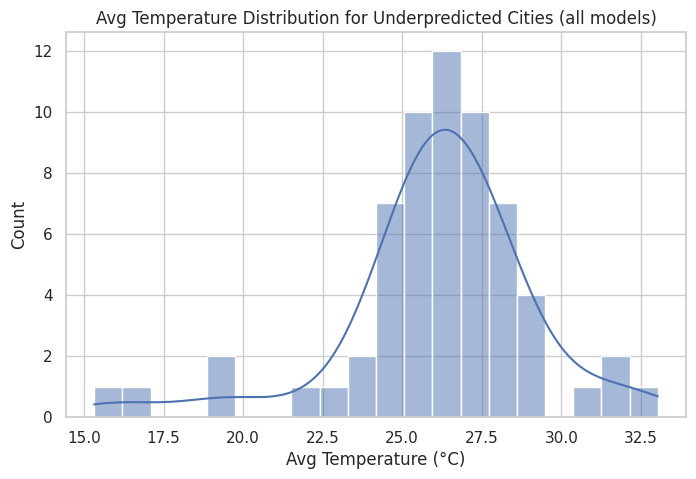

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

under_all_with_temp_clean = under_all_with_temp.dropna(subset=["avg_temp"])

plt.figure(figsize=(8,5))
sns.histplot(under_all_with_temp_clean["avg_temp"], bins=20, kde=True)
plt.title("Avg Temperature Distribution for Underpredicted Cities (all models)")
plt.xlabel("Avg Temperature (°C)")
plt.show()


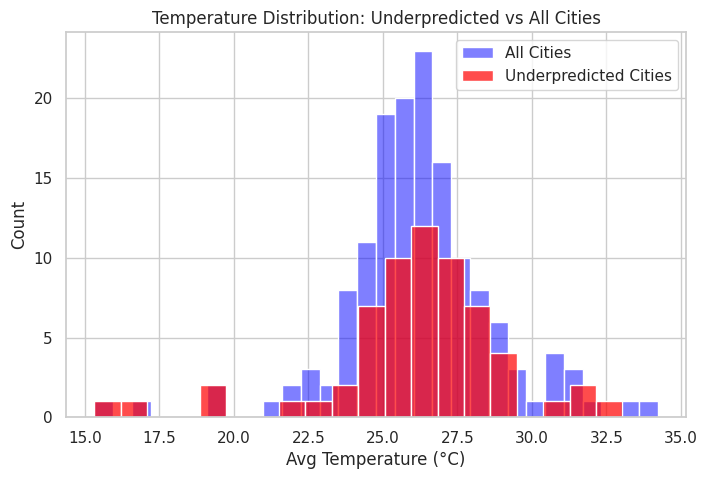

In [56]:
plt.figure(figsize=(8,5))
sns.histplot(avg_temp_per_city["avg_temp"].dropna(), bins=30, color='blue', label='All Cities', alpha=0.5)
sns.histplot(under_all_with_temp_clean["avg_temp"], bins=20, color='red', label='Underpredicted Cities', alpha=0.7)
plt.title("Temperature Distribution: Underpredicted vs All Cities")
plt.xlabel("Avg Temperature (°C)")
plt.legend()
plt.show()


In [57]:
from scipy.stats import mannwhitneyu

all_temps = avg_temp_per_city["avg_temp"].dropna()
under_temps = under_all_with_temp_clean["avg_temp"]

stat, p = mannwhitneyu(under_temps, all_temps, alternative='two-sided')
print(f"Mann-Whitney U test p-value: {p:.4f}")

if p < 0.05:
    print("Temperature distributions differ significantly between underpredicted cities and all cities.")
else:
    print("No significant difference in temperature distributions.")


Mann-Whitney U test p-value: 0.6585
No significant difference in temperature distributions.


In [60]:
# Add a temp_bin column
bins = [float('-inf'), 20, 30, float('inf')]
labels = ['<=20°C', '20-30°C', '>30°C']

under_all_with_temp_clean = under_all_with_temp_clean.copy()
under_all_with_temp_clean.loc[:, 'temp_bin'] = pd.cut(
    under_all_with_temp_clean['avg_temp'], bins=bins, labels=labels
)

avg_temp_per_city = avg_temp_per_city.copy()
avg_temp_per_city.loc[:, 'temp_bin'] = pd.cut(
    avg_temp_per_city['avg_temp'], bins=bins, labels=labels
)

total_counts = avg_temp_per_city.groupby('temp_bin', observed=True).size()
under_counts = under_all_with_temp_clean.groupby('temp_bin', observed=True).size()

# Combine into a dataframe and compute proportions
temp_summary = pd.DataFrame({
    'Total Cities': total_counts,
    'Underpredicted Cities': under_counts
}).fillna(0)

temp_summary['Underprediction Rate (%)'] = (temp_summary['Underpredicted Cities'] / temp_summary['Total Cities']) * 100

print(temp_summary)


          Total Cities  Underpredicted Cities  Underprediction Rate (%)
temp_bin                                                               
<=20°C               4                      4                100.000000
20-30°C            133                     54                 40.601504
>30°C               10                      4                 40.000000


### Contour plots to know spatial behaviour

In [5]:
city_boundries = gpd.read_file("AirQuality/RQ3/Dataset/IntermediateData_201Cities/city_boundaries_all.geojson")
city_boundries

,city,state,query,geometry
0,Agartala,Tripura,"Agartala, Tripura, India","POLYGON ((91.38238 23.83124, 91.3819 23.82144,..."
1,Agra,Uttar Pradesh,"Agra, Uttar Pradesh, India","POLYGON ((77.85102 27.15764, 77.85103 27.15734..."
2,Ahmedabad,Gujarat,"Ahmedabad, Gujarat, India","POLYGON ((71.83998 22.32574, 71.84003 22.32543..."
3,Aizawl,Mizoram,"Aizawl, Mizoram, India","POLYGON ((92.62402 23.7976, 92.62543 23.79614,..."
4,Ajmer,Rajasthan,"Ajmer, Rajasthan, India","POLYGON ((74.5916 26.48066, 74.59576 26.46199,..."
...,...,...,...,...
196,Vijayawada,Andhra Pradesh,"Vijayawada, Andhra Pradesh, India","POLYGON ((80.54196 16.55055, 80.54691 16.54735..."
197,Visakhapatnam,Andhra Pradesh,"Visakhapatnam, Andhra Pradesh, India","MULTIPOLYGON (((83.10981 17.69193, 83.11083 17..."
198,Vrindavan,Uttar Pradesh,"Vrindavan, Uttar Pradesh, India","POLYGON ((77.7938 27.57537, 77.79332 27.56557,..."
199,Yadgir,Karnataka,"Yadgir, Karnataka, India","POLYGON ((76.29135 16.33054, 76.29179 16.33051..."


In [6]:
gt_df["month"].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December'],
      dtype=object)

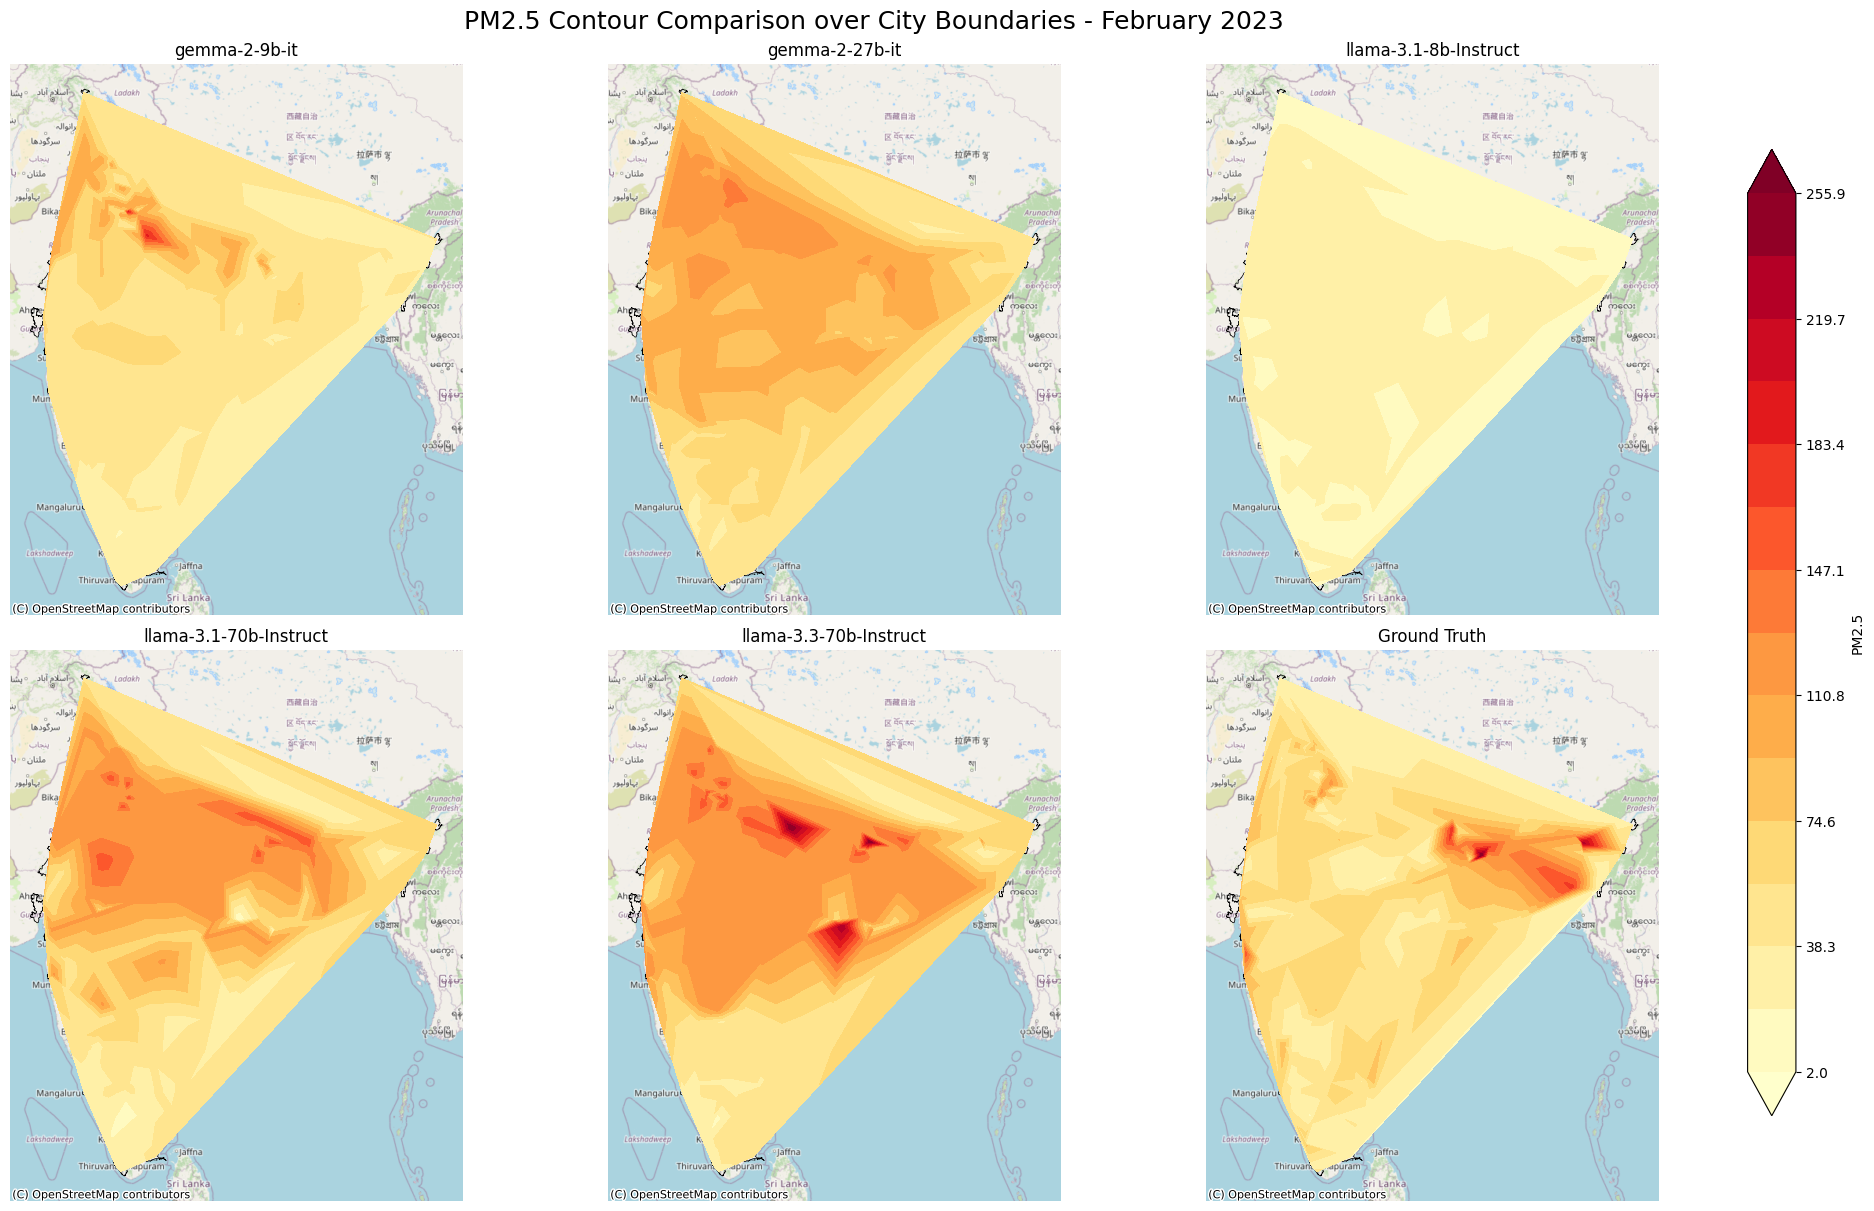

In [9]:
# === Load city boundaries ===
city_boundaries = gpd.read_file("AirQuality/RQ3/Dataset/IntermediateData_201Cities/city_boundaries_all.geojson")
city_boundaries = city_boundaries.to_crs(epsg=3857)  # Convert to Web Mercator for basemap

# === Define month ===
month_to_plot = "February"

# === Convert all lat/lon points to GeoDataFrame (for plotting) ===
merged_gdfs = {}
for model_name, df in model_dfs.items():
    df_month = df[df["month"] == month_to_plot].dropna(subset=["pm2.5"])
    df_month = pd.merge(df_month, gt_df[["city", "state", "year", "month", "latitude", "longitude"]],
                        on=["city", "state", "year", "month"], how="left")
    gdf = gpd.GeoDataFrame(
        df_month,
        geometry=gpd.points_from_xy(df_month.longitude, df_month.latitude),
        crs="EPSG:4326"
    ).to_crs(epsg=3857)
    merged_gdfs[model_name] = gdf

# Ground truth as GeoDataFrame
gt_month = gt_df[gt_df["month"] == month_to_plot].dropna(subset=["ground_truth_pm25"])
gt_gdf = gpd.GeoDataFrame(
    gt_month,
    geometry=gpd.points_from_xy(gt_month.longitude, gt_month.latitude),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# === Common color scale ===
all_pm25_vals = [gdf["pm2.5"] for gdf in merged_gdfs.values()] + [gt_gdf["ground_truth_pm25"]]
vmin = min([vals.min() for vals in all_pm25_vals])
vmax = max([vals.max() for vals in all_pm25_vals])
levels = np.linspace(vmin, vmax, 15)

# === Plotting ===
fig, axes = plt.subplots(2, 3, figsize=(20, 12), constrained_layout=True)
axes = axes.flatten()
cmap = "YlOrRd"

# === Plot each model ===
for i, (model_name, gdf) in enumerate(merged_gdfs.items()):
    ax = axes[i]
    
    # Plot city boundaries
    city_boundaries.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5)
    
    # Scatter plot as filled contour
    sc = ax.tricontourf(
        gdf.geometry.x, gdf.geometry.y, gdf["pm2.5"],
        levels=levels, cmap=cmap, extend='both'
    )

    ax.set_title(model_name)
    ax.set_axis_off()
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# === Last plot: Ground truth ===
ax = axes[-1]
city_boundaries.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5)
sc_gt = ax.tricontourf(
    gt_gdf.geometry.x, gt_gdf.geometry.y, gt_gdf["ground_truth_pm25"],
    levels=levels, cmap=cmap, extend='both'
)
ax.set_title("Ground Truth")
ax.set_axis_off()
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# === Colorbar ===
fig.colorbar(sc_gt, ax=axes, orientation='vertical', shrink=0.85, label="PM2.5")

# === Title ===
fig.suptitle(f"PM2.5 Contour Comparison over City Boundaries - {month_to_plot} 2023", fontsize=18)

plt.show()

In [17]:
import contextily as ctx
print(ctx.providers.keys())


dict_keys(['OpenStreetMap', 'MapTilesAPI', 'OpenSeaMap', 'OPNVKarte', 'OpenTopoMap', 'OpenRailwayMap', 'OpenFireMap', 'SafeCast', 'Stadia', 'Thunderforest', 'BaseMapDE', 'CyclOSM', 'Jawg', 'MapBox', 'MapTiler', 'TomTom', 'Esri', 'OpenWeatherMap', 'HERE', 'HEREv3', 'FreeMapSK', 'MtbMap', 'CartoDB', 'HikeBike', 'BasemapAT', 'nlmaps', 'NASAGIBS', 'NLS', 'JusticeMap', 'GeoportailFrance', 'OneMapSG', 'USGS', 'WaymarkedTrails', 'OpenAIP', 'OpenSnowMap', 'AzureMaps', 'SwissFederalGeoportal', 'TopPlusOpen', 'Gaode', 'Strava', 'OrdnanceSurvey', 'UN'])


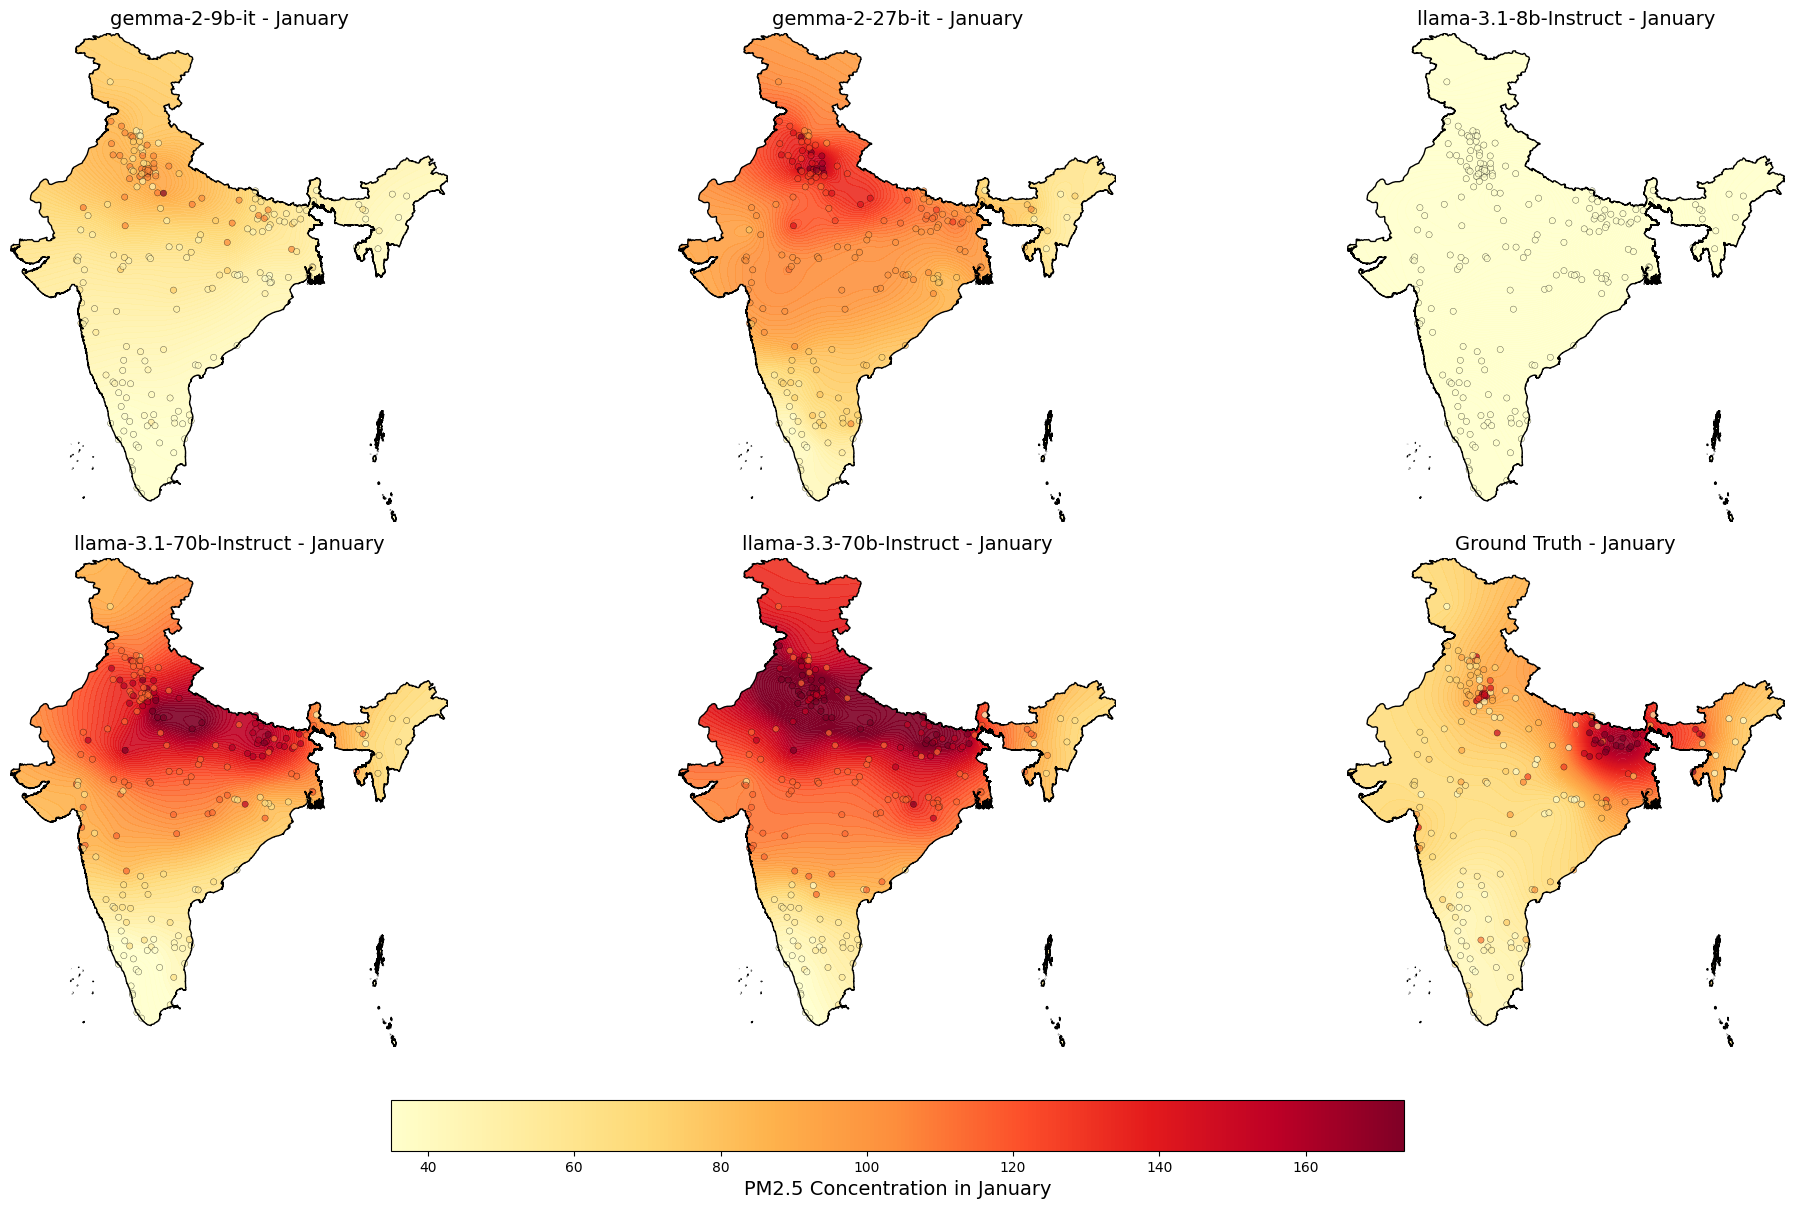

In [24]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from shapely.geometry import Point
import matplotlib.colors as mcolors
from matplotlib import colormaps

# --- CONFIG ---
selected_month = "January"
india_boundary_path = "AirQuality/RQ3/Dataset/India-State-and-Country-Shapefile-Updated-Jan-2020/India_Country_Boundary.shp"

# --- Load India shape ---
india_gdf = gpd.read_file(india_boundary_path).to_crs(epsg=4326)
minx, miny, maxx, maxy = india_gdf.total_bounds
grid_lon = np.linspace(minx, maxx, 500)
grid_lat = np.linspace(miny, maxy, 500)
grid_x, grid_y = np.meshgrid(grid_lon, grid_lat)

# === FIX 1 ===
grid_points = gpd.GeoSeries([Point(x, y) for x, y in zip(grid_x.flatten(), grid_y.flatten())], crs="EPSG:4326")
mask = grid_points.within(india_gdf.geometry.union_all()).values.reshape(grid_x.shape)

# === Kriging function ===
def kriging_interpolation(lon, lat, values, grid_lon, grid_lat, mask):
    OK = OrdinaryKriging(
        lon, lat, values,
        variogram_model="linear",
        verbose=False,
        enable_plotting=False,
        coordinates_type="geographic"
    )
    z, _ = OK.execute("grid", grid_lon, grid_lat)
    return np.where(mask, z, np.nan)

# === Interpolation per model ===
titles = list(model_dfs.keys()) + ["Ground Truth"]
plot_data = []

for model_name, model_df in model_dfs.items():
    df = model_df[model_df["month"] == selected_month]
    gt_filtered = gt_df[gt_df["month"] == selected_month]
    df = pd.merge(df, gt_filtered, on=["city", "state", "year", "month"], how="inner")
    df = df.rename(columns={"pm2.5": "pm25_pred"}).dropna(subset=["latitude", "longitude", "pm25_pred"])
    if df.empty:
        plot_data.append(np.full(grid_x.shape, np.nan))
        continue
    z_krig = kriging_interpolation(df["longitude"].values, df["latitude"].values, df["pm25_pred"].values,
                                   grid_lon, grid_lat, mask)
    plot_data.append(z_krig)

# Ground truth
gt_df_month = gt_df[gt_df["month"] == selected_month].dropna(subset=["latitude", "longitude", "ground_truth_pm25"])
if not gt_df_month.empty:
    z_gt = kriging_interpolation(gt_df_month["longitude"].values, gt_df_month["latitude"].values,
                                  gt_df_month["ground_truth_pm25"].values,
                                  grid_lon, grid_lat, mask)
else:
    z_gt = np.full(grid_x.shape, np.nan)
plot_data.append(z_gt)

# === FIX 3: Use constrained_layout ===
fig, axes = plt.subplots(2, 3, figsize=(20, 12), subplot_kw={"aspect": "equal"}, constrained_layout=True)
axes = axes.flatten()

vmin = np.nanmin(z_gt)
vmax = np.nanmax(z_gt)
# norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
vpad = 0.05 * (vmax - vmin)
norm = mcolors.Normalize(vmin=vmin - vpad, vmax=vmax + vpad)

# === FIX 2: Use new cmap loader ===
cmap = colormaps["YlOrRd"]

# for i, ax in enumerate(axes):
#     ax.set_title(f"{titles[i]} - {selected_month}", fontsize=14)
#     contour = ax.contourf(grid_x, grid_y, plot_data[i], levels=100, cmap=cmap, norm=norm, alpha=0.9)
#     india_gdf.boundary.plot(ax=ax, color="black", linewidth=1)
#     ax.set_xlim([minx, maxx])
#     ax.set_ylim([miny, maxy])
#     ax.axis("off")

for i, ax in enumerate(axes):
    z = plot_data[i]

    # Check for empty or invalid data
    if np.isnan(z).all() or np.nanmin(z) == np.nanmax(z):
        ax.set_title(f"{titles[i]} - {selected_month}\n(No valid data)", fontsize=12, color="gray")
        ax.axis("off")
        continue

    ax.set_title(f"{titles[i]} - {selected_month}", fontsize=14)
    contour = ax.contourf(grid_x, grid_y, z, levels=100, cmap=cmap, norm=norm, alpha=0.9)
    india_gdf.boundary.plot(ax=ax, color="black", linewidth=1)
    ax.set_xlim([minx, maxx])
    ax.set_ylim([miny, maxy])
    ax.axis("off")


cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes, orientation="horizontal", fraction=0.05, pad=0.05)
cbar.set_label(f"PM2.5 Concentration in {selected_month}", fontsize=14)

# === Plot city markers for each subplot ===
for i, ax in enumerate(axes):
    if i == len(axes) - 1:
        # Last one is ground truth
        df_cities = gt_df_month
        color_values = df_cities["ground_truth_pm25"]
    else:
        # Model predictions
        model_df = model_dfs[titles[i]]
        df_model = model_df[model_df["month"] == selected_month]
        df_model = pd.merge(df_model, gt_df_month, on=["city", "state", "year", "month"], how="inner")
        df_model = df_model.rename(columns={"pm2.5": "pm25_pred"}).dropna(subset=["latitude", "longitude", "pm25_pred"])
        if df_model.empty:
            continue
        df_cities = df_model
        color_values = df_cities["pm25_pred"]

    ax.scatter(
        df_cities["longitude"], 
        df_cities["latitude"], 
        c=color_values,
        cmap=cmap,
        norm=norm,
        s=20,
        edgecolor="black",
        linewidth=0.3,
        alpha=0.7,
        marker="o"
    )

plt.show()

##### Generate shape file for india

In [8]:
GLOBAL_COUNTRIES_SHAPEFILE_PATH = "AirQuality/RQ3/Dataset/countries_shape_files/ne_10m_admin_0_countries.shp"

try:
    all_countries_gdf = gpd.read_file(GLOBAL_COUNTRIES_SHAPEFILE_PATH)

    
    india_boundary_gdf = all_countries_gdf[all_countries_gdf['NAME'] == 'India']

    if india_boundary_gdf.empty:
        print("Error: 'India' not found in the 'NAME' column. Please check the exact country name.")
        exit()

    india_boundary_gdf = india_boundary_gdf.reset_index(drop=True)
    india_boundary_gdf = india_boundary_gdf.to_crs(epsg=4326)

    print("Successfully loaded and filtered India's boundary shapefile:")
    print(india_boundary_gdf.head())
    print(f"CRS: {india_boundary_gdf.crs}")

except FileNotFoundError:
    print(f"Error: Global countries shapefile not found at {GLOBAL_COUNTRIES_SHAPEFILE_PATH}")
    print("Please ensure the path is correct.")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully loaded and filtered India's boundary shapefile:
        featurecla  scalerank  LABELRANK SOVEREIGNT SOV_A3  ADM0_DIF  LEVEL  \
0  Admin-0 country          0          2      India    IND         0      2   

                TYPE TLC  ADMIN  ... FCLASS_TR  FCLASS_ID FCLASS_PL FCLASS_GR  \
0  Sovereign country   1  India  ...      None       None      None      None   

   FCLASS_IT FCLASS_NL FCLASS_SE  FCLASS_BD FCLASS_UA  \
0       None      None      None       None      None   

                                            geometry  
0  MULTIPOLYGON (((77.80035 35.49541, 77.81533 35...  

[1 rows x 169 columns]
CRS: EPSG:4326


In [10]:
india_boundary_gdf.to_file("AirQuality/RQ3/Dataset/india_boundry_filtered.shp")

/opt/anaconda3/envs/diya_env/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 1366417754 of field POP_EST of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
